In [ ]:
import os
import re
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from  keras . utils  import  to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.initializers import Constant
from keras.layers import Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd 
df_train=pd.read_csv('gdrive/My Drive/Thesis Data/Our dataset/OurDataset_train.csv')
df_test=pd.read_csv('gdrive/My Drive/Thesis Data/Our dataset/OurDataset_test.csv')


In [ ]:
!git clone -l -s https://github.com/banglakit/bengali-stemmer.git

Cloning into 'bengali-stemmer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 16 (delta 4), pack-reused 69
Unpacking objects: 100% (94/94), done.


In [ ]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-l1qpdmwk
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-l1qpdmwk
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=89930503b9cc8d2f890be601700c8cbdc5b73ac95e7b7bd4ac9e73dee13a190c
  Stored in directory: /tmp/pip-ephem-wheel-cache-n7hmxdnj/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [ ]:
!pip install git+https://github.com/banglakit/bengali-stemmer.git    

  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-hh1kfi1f
  Running command git clone -q https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-hh1kfi1f
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6393 sha256=1139e4cc30fc57a89933a10c53872f57d3837fb80124080aee48343300ce4091
  Stored in directory: /tmp/pip-ephem-wheel-cache-fmnj53z_/wheels/a1/ad/a1/4ba354059b17c00600a14e13a504e7bdb49f20f2f4e2f3639c
Successfully built bengali-stemmer


In [ ]:
from bengali_stemmer.rafikamal2014 import RafiStemmer
stemmer = RafiStemmer()
stemmer.stem_word('বাংলায়')

'বাংলা'

In [ ]:
total_data = df_train
total_data=total_data.append(df_test, ignore_index = True)

In [ ]:
macronum=sorted(set(total_data['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

total_data['label']=total_data['label'].apply(fun)


In [ ]:
texts = list(total_data['text'])
labels = list(total_data['label'])


In [ ]:
def clean_punct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#|।|’|‘]', r'', sentence)
    cleaned1 = re.sub(r'[.|,|(|)|\|/]', r'', cleaned)
    cleaned = re.sub(r'[০|১|২|৩|৪|৫|৬|৭|৮|৯]', r'', cleaned1)
    cleaned1 = re.sub(r'[-|=]', r' ', cleaned)
    return cleaned1

In [ ]:
stopwords = pd.read_csv('gdrive/My Drive/Colab Notebooks/Stopwords.csv')

In [ ]:
set_stop = set(stopwords['words'])

In [ ]:

def pre_process(data):
    i=0
    str1=' '
    final_string = []
    final_words = []
    all_negative_words = []
    s=''

    for sentence in data:
        filtered_sentence = []

        for w in sentence.split():
            for cleaned_word in clean_punct(w).split():
                if len(cleaned_word)>2:
                    if((cleaned_word) not in set_stop):
                        s = stemmer.stem_word(cleaned_word)
                        if len(s)>2:
                            final_words.append(s)
                            filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue

        str1 = " ".join(filtered_sentence)
        final_string.append(str1)
    return final_string

In [ ]:
texts = pre_process(texts)

In [ ]:
texts[0]

'দূর ভরত হেস উঠল আপন বালিকা বধূ স্কুল পাঠানো সরলা বিবির টানাটানি সরলা বেথুন স্কুল লোরে হাউজ দুজন ধারণা স্কুল ভালো বেথুন স্কুল বাঙা পাড়া বাংলা মাধ্যম লোরেটো হাউজ সাহেব পাড় ইংরেজি স্কুল বাঙা ছাত্রীর তুলনা ফিরিঙ্গি ছাত্রী বেথুন ছাত্রী সমাজ নাম মহিলা বছর বেথুন ছাত্রী হইচ প্রবেশিকা পরীক্ষা ভালোভাব উত্তীর্ণ অবলা দাস নাম মেয়ে ডাক্তারি পড়ব কলকাতা মেডিক কলেজ ছাত্রী নেয়া অবল কেনো ডাক্তারি পারব শেষ পাঠি মাদ্রাজ মেডিক কলেজ অবল জেদ বাঙলা সরক কুড়ি টাক মাসিক বৃত্তির অনুমোদন দেশ কোথা আন্দোলন বেথুন কলেজ প্রভাব ইলবার্ট বিল সাহেব দেশী মানুষ বিদ্য বুদ্ধি প্রচ লাগল কামিনী নাম তেজস্বিনী ছাত্রীর নেতৃত্ব বেথুন বিক্ষোভ জানি সুর বাড়ুজ্য যেদিন সেদিন বেথুন ছাত্রী কালো বেধ স্কুল লোরেটো হাউজ এসব স্বদেশিয়ানা নিষিদ্ধ প্রভু যিশুর জয়গান নিয়মিত প্রার্থনা ছাত্রী ভালো ইংরেজি শেখ বিলিতি আদব কায়দা রপ্ত পাস ব্যারিস্ পত্নী হিসেব মানি বিবির বয়েস বছর সরল এগারো মামা পিসতু বোন ভাব মাঝ মাঝ তর্ক বয়েস সরল ইংরেজ শাসন সম্পর্ রাগ রাগ ভাব প্রা আবৃত্তি স্বাধীনতা হীনতা বাঁচি বাঁচি বয়েসী পরিবার নিয়ম কাকিমা মামী সরলা ছুট দুজন হাত ইক

In [ ]:
def load_data(num_words, sequence_length, test_size=0.25, oov_token=None):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    num_classes=16
    y = to_categorical(np.asarray(labels), num_classes)
    tokenizer.fit_on_texts(texts)
    X = tokenizer.texts_to_sequences(texts)
    X = np.array(X)
    # pad sequences with 0's
    X = pad_sequences(X, maxlen=sequence_length)
    # split data to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    data = {}
    data["X_train"] = X_train
    data["X_test"]= X_test
    data["y_train"] = y_train
    data["y_test"] = y_test
    data["tokenizer"] = tokenizer
    return data

In [ ]:
# train_data=pd.read_csv('gdrive/My Drive/Colab Notebooks/ulm_train.csv')
import numpy as np

def get_embedding_vectors(word_index, embedding_size=100):
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
    with open(f"gdrive/My Drive/Colab Notebooks/bn_glove.{embedding_size}d.txt", encoding="utf8") as f:
        for line in tqdm(f, "Reading GloVe"):
            values = line.split()
            # get the word as the first word in the line
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                # get the vectors as the remaining values in the line
                embedding_matrix[idx] = np.array(values[1:], dtype="float32")
    return embedding_matrix

In [ ]:
len(data['tokenizer'].word_index)

NameError: ignored

In [ ]:
d = set()
for s in texts:
    for ss in list(s.split()):
        d.add(ss)

In [ ]:
len(d)

284632

In [ ]:
max([len(s.split()) for s in texts]) # find the max length

606

In [ ]:
MAX_SEQUENCE_LENGTH = 606    #max([len(s.split()) for s in texts]) 
MAX_NUM_WORDS = 280432 + 1
vocab_size = MAX_NUM_WORDS
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

data = load_data(MAX_NUM_WORDS , MAX_SEQUENCE_LENGTH,VALIDATION_SPLIT)

In [ ]:
len(data['tokenizer'].word_index)

280432

In [ ]:
embedding_matrix = get_embedding_vectors( data['tokenizer'].word_index ,EMBEDDING_DIM )

Reading GloVe: 134256it [00:10, 12997.86it/s]


In [ ]:
# create the model
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(MAX_NUM_WORDS, embedding_vecor_length,  weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(100))
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 606, 300)          84129900  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
Total params: 84,291,916
Trainable params: 84,291,916
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_test'], data['y_test']), epochs=10, verbose=2)

Epoch 1/10
450/450 - 892s - loss: 2.1542 - accuracy: 0.3316 - val_loss: 1.8341 - val_accuracy: 0.4580
Epoch 2/10
450/450 - 915s - loss: 1.4714 - accuracy: 0.5380 - val_loss: 1.2502 - val_accuracy: 0.6297
Epoch 3/10
450/450 - 917s - loss: 0.7475 - accuracy: 0.7942 - val_loss: 0.5410 - val_accuracy: 0.8600
Epoch 4/10
450/450 - 904s - loss: 0.2371 - accuracy: 0.9450 - val_loss: 0.6138 - val_accuracy: 0.8086
Epoch 5/10
450/450 - 900s - loss: 0.1139 - accuracy: 0.9779 - val_loss: 0.2624 - val_accuracy: 0.9299
Epoch 6/10
450/450 - 895s - loss: 0.0395 - accuracy: 0.9941 - val_loss: 0.2070 - val_accuracy: 0.9466
Epoch 7/10
450/450 - 881s - loss: 0.0410 - accuracy: 0.9932 - val_loss: 0.1779 - val_accuracy: 0.9563
Epoch 8/10
450/450 - 880s - loss: 0.0100 - accuracy: 0.9994 - val_loss: 0.1390 - val_accuracy: 0.9661
Epoch 9/10
450/450 - 880s - loss: 0.0077 - accuracy: 0.9989 - val_loss: 0.1498 - val_accuracy: 0.9633
Epoch 10/10
450/450 - 879s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1244 - 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confussion_mat(model):
    # Predict the values from the validation dataset
    Y_pred = model.predict(data['X_test'])
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(data['y_test'],axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def history2(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


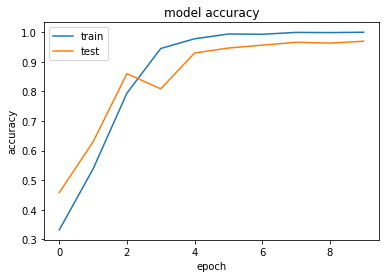

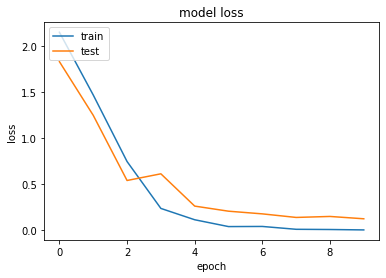

In [ ]:
history2(history)

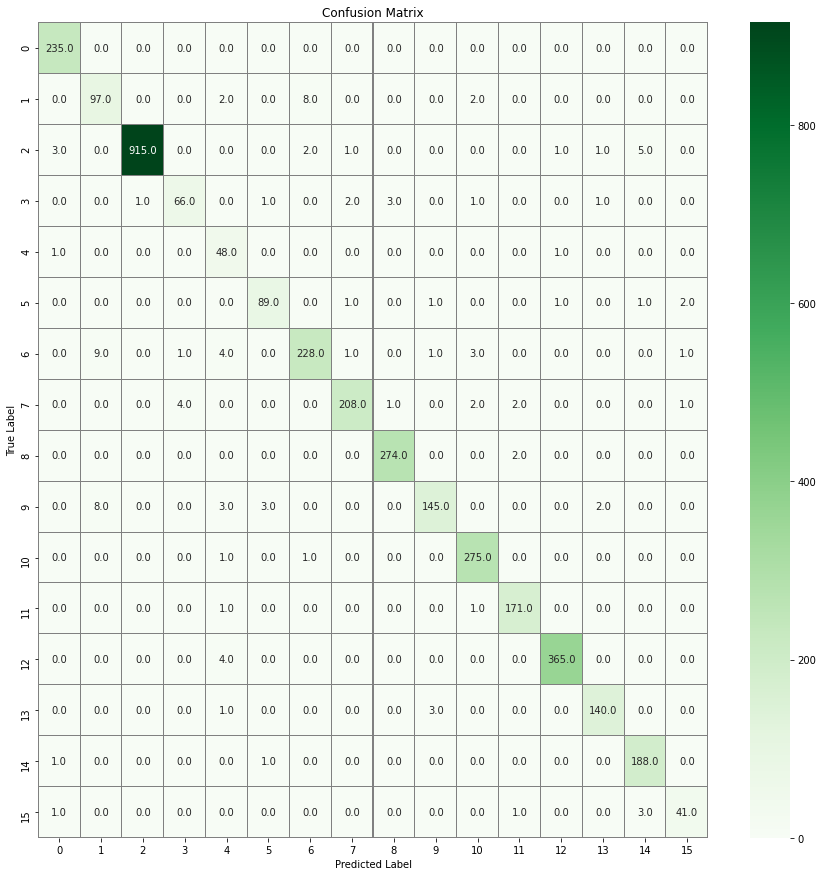

In [ ]:
confussion_mat(model)